# Tarea 3 Regularización y Generalización <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: Matías Rojas
Fecha de entrega: 1 de octubre de 2019

In [0]:
# Cabe mencionar que se utilizará como base el código proporcionado por Jesús.

import torch
import random

def sig(T, gradient=False):
  if gradient:
    sigT = sig(T)
    return sigT * (1 - sigT)
  return torch.reciprocal(1 + torch.exp(-1 * T))
  
def tanh(T, gradient=False):
  if gradient:
    tanhT = tanh(T)
    return 1 - tanhT * tanhT
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

def relu(T, gradient=False):
  if gradient:
    outT = torch.zeros_like(T)
    outT[T>=0] = 1
    return outT
  return torch.max(T, torch.zeros_like(T))

def swish(T, beta=1, gradient=False):
  if gradient:
    sigbT = sig(beta * T)
    swishT = T * sigbT
    return sigbT + beta * swishT * (1 - sigbT), swishT * (T - swishT)
  return T * torch.reciprocal(1 + torch.exp(-beta * T))

def celu(T, alpha=1, gradient=False):
  if alpha == 0:
    raise ValueError("alpha cannot be 0")

  zeros = torch.zeros_like(T)
  Talpha = T / alpha
  
  if gradient:
    e = Talpha.exp()
    d_dx = torch.ones_like(T)
    d_dx[T<0] = e[T<0]
    zeros[T<0] = (celu(T)[T<0] - T[T<0] * e[T<0]) / alpha
    return d_dx, zeros # d_dx, d_da
  
  return torch.max(zeros, T) + torch.min(zeros, alpha * (Talpha).expm1())

def softmax(T, dim, estable=True):
  if estable:
    T -= T.max(dim=dim, keepdim=True)[0]  # keepdim=True => output has dim with size 1. Otherwise, dim is squeezed
  exp = torch.exp(T)
  return exp / torch.sum(exp, dim=dim, keepdim=True)  # keepdim=True => output has dim with size 1. Otherwise, dim is squeezed

def CELoss(Q, P, estable=True, epsilon=1e-7):
  if estable:
    Q = Q.clamp(epsilon, 1-epsilon)
  return -(P * Q.log()).sum()/Q.size(0)
  

In [0]:

def crearMascara(probs, neuronascapa,device):
  mascara = []    
  for i in range(len(neuronascapa)):     
    mask = ((torch.FloatTensor(neuronascapa[i]).uniform_())>(1-probs[i])).float()
    mask2 = mask.t()
    mascara+=[mask2.to(device)]
  return mascara


# Parte 1: Regularización por norma $L_2$


## "Penalización de norma L2 en la pérdida" + "Regularización por dropout" (1a + Parte 2)

In [0]:
class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, l_a_params, C,  l2_par=None, keep_prob=None):
    super(FFNN, self).__init__()
    sizes = [F] + l_h + [C]
    self.Ws = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(sizes[i], sizes[i+1])) for i in range(len(sizes)-1)])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(h)) for h in sizes[1:]])
    self.fs = l_a
    self.fs_ps = torch.nn.ParameterList([torch.nn.Parameter(torch.tensor(p)) if p else None for p in l_a_params])
    self.cache = []
    self.probs = keep_prob
    self.sizes = sizes
    self.l2_par = l2_par
    self.mask = None
    self.predict = False
    self.sizes2 = [F] + l_h
  @property
  def in_size(self):
    return self.Ws[0].shape[0]
    
  def load_weights(self, Ws, U, bs, c):
    self.Ws = torch.nn.ParameterList([torch.nn.Parameter(W) for W in Ws + [U]])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(b) for b in bs + [c]])
  
  def resumen(self):
    for name, p in self.named_parameters():
      print('{}:\t{}'.format(name, p.size()))
    pass
 
   
  def forward(self, x, predict, device):
    self.mask = []
    self.mask = crearMascara(self.probs, self.sizes2,device)
    self.cacheU = [] 
    self.predict = predict
    i = 0
    x = x.mul(self.mask[0])*(1/self.probs[0])
    for W, b, f, p in zip(self.Ws[:-1], self.bs[:-1], self.fs, self.fs_ps):
      i+=1
      x = torch.mm(x, W) + b
      self.cacheU.append(x)
      x = f(x) if p is None else f(x, p.item())
      if self.predict==False:
        x = x*(self.mask[i])*(1/self.probs[i])
    
    return softmax(torch.mm(x, self.Ws[-1]) + self.bs[-1], dim=1)
  
  # nuevo código Tarea 2
  def backward(self, x, y, y_pred):
    current_grad =  (y_pred - y) / y.size(0) 
    for i in range(len(self.Ws)-1, 0, -1):
      if self.l2_par!=None:
        self.Ws[i].grad = (self.fs[i-1](self.cacheU[i-1]).t() @ current_grad) + (self.l2_par/x.size()[0])*self.Ws[i]
      else:
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1]).t() @ current_grad 
        
      self.bs[i].grad = current_grad.sum(dim=0)
      h_grad = (current_grad @ self.Ws[i].t())*(self.mask[i])*(1/self.probs[i]) if self.predict!= True else current_grad @ self.Ws[i].t()
      
      if self.fs_ps[i-1] is None:
        current_grad = self.fs[i-1](self.cacheU[i-1], gradient=True) * h_grad  
      else:
        current_grad, p_grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps[i-1], gradient=True) 
        current_grad *= h_grad
        self.fs_ps[i-1].grad = (p_grad * h_grad).sum()

    if self.l2_par!=None:
      self.Ws[0].grad = x.t() @ current_grad + (self.l2_par/x.size()[0])*self.Ws[0]
    else:
      self.Ws[0].grad = x.t() @ current_grad 
    self.bs[0].grad = current_grad.sum(dim=0) 

In [0]:
# Acá agrega tu código para computar la pérdida con penalización

def RegLoss(Q, P, params, l2_par=None):
  sum = 0
  for i in range(len(params)):
    if params[i].shape[0]==2:
      b = params[i].pow(2)
      a = b.sum()
      sum+=a
  celossR = CELoss(Q, P, estable=True, epsilon=1e-7)
  result = celossR + (l2_par/(2*Q.size(0)))*sum
  return celossR + result


## 1b) Regularización por weight decay

In [0]:
class SGD():
  def __init__(self, parameters, lr, weight_decay):
    self.params = list(parameters)
    self.lr = lr
    self.weight_decay = weight_decay
  
  def step(self):
    for p in self.params:
      if p.shape[0]==2:
        p.data =(1-self.weight_decay)*p.data
      p.data -= p.grad * self.lr

#Parte 3: Entrenamiento y generalización sobre MNIST

In [0]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import sys
import time
from torch.utils.data import Dataset, DataLoader



def entrenar_FFNN(red, train, test, optimizador, epochs=10, batch_size=10, reports_every=1, device='cuda', regloss=False):
  red.to(device)
  data = DataLoader(train, batch_size, shuffle=True)
  total=len(train)
  tiempo_epochs = 0
  loss, acc = [], []
  loss_test, acc_test = [], []
  for e in range(1,epochs+1):  
    inicio_epoch = time.clock()
    for x, y in data:
      x, y = x.view(x.size(0), -1).float().to(device), y.to(device)
      y_pred = red(x,False,device).to(device)
      y_onehot = torch.zeros_like(y_pred)
      y_onehot[torch.arange(x.size(0)), y] = 1.
      red.backward(x, y_onehot, y_pred)
      optimizador.step() 
      
    tiempo_epochs += time.clock() - inicio_epoch
    
    if e % reports_every == 0:
      X = train.data.view(len(train), -1).float().to(device)
      Y = train.targets.to(device)
      Y_PRED = red.forward(X,True,device).to(device)
      Y_ONEHOT = torch.zeros_like(Y_PRED)
      Y_ONEHOT[torch.arange(X.size(0)), Y] = 1.
      
      if not regloss:
        L_total = CELoss(Y_PRED, Y_ONEHOT)
      else:
        L_total = RegLoss(Y_PRED, Y_ONEHOT, red.Ws, red.l2_par)
      loss.append(L_total)
      diff = Y-torch.argmax(Y_PRED,1)
      errores = torch.nonzero(diff).size(0)
      total = len(train)
      Acc=100*(total-errores)/total
      acc.append(Acc)
      
      Xtest = test.data.view(len(test), -1).float().to(device)
      Ytest = test.targets.to(device)
      Y_PREDTEST = red.forward(Xtest,True,device).to(device)
      Y_ONEHOTPRED = torch.zeros_like(Y_PREDTEST)
      Y_ONEHOTPRED[torch.arange(Xtest.size(0)), Ytest] = 1.
      
      if not regloss:
        L_totaltest = CELoss(Y_PREDTEST, Y_ONEHOTPRED)
      else:
        L_totaltest = RegLoss(Y_PREDTEST, Y_ONEHOTPRED, red.Ws, red.l2_par)
      loss_test.append(L_totaltest)
      diff2 = Ytest-torch.argmax(Y_PREDTEST,1)
      errores2 = torch.nonzero(diff2).size(0)
      total2 = len(test)
      Acc_test=100*(total2-errores2)/total2
      acc_test.append(Acc_test)
      
      
      sys.stdout.write(
            '\rEpoch:{0:03d}'.format(e) + ' Acc:{0:.2f}%'.format(Acc_test)
            + ' Loss:{0:.4f}'.format(L_totaltest) 
            + ' Tiempo/epoch:{0:.3f}s'.format(tiempo_epochs/e))
            
            
  
  return (loss, acc, loss_test, acc_test)


mnist_train_set = MNIST('mnist', train=True, transform=ToTensor(), download=True)
mnist_test_set = MNIST('mnist', train=False, transform=ToTensor(), download=True)
print('Datos de train: {}, Datos de test: {}'.format(len(mnist_train_set), len(mnist_test_set)))




Datos de train: 60000, Datos de test: 10000


Primera configuración: Se utiliza regularización por weight decay.

Epoch:200 Acc:88.37% Loss:0.4392 Tiempo/epoch:11.957s

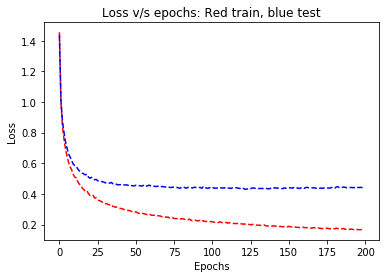

Text(0.5, 1.0, 'ACC v/s epochs: Red train, blue test')

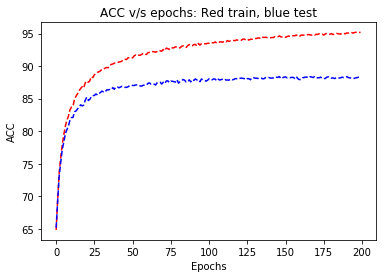

In [0]:
import matplotlib.pyplot as plt
C = 10
F = 784
model = FFNN(F, [256, 128, 64], [relu, sig, relu], [None, None, None], C, l2_par=None, keep_prob=[1.0,1.0,1.0,1.0])  
optimizer = SGD(model.parameters(), 1e-2,0.000004)

with torch.no_grad():
  loss, acc, loss_test, acc_test = entrenar_FFNN(model, mnist_train_set, mnist_test_set, optimizer, epochs=200, batch_size=32)
  import numpy as np


t = np.arange(0,200,1)
plt.plot(t, loss, 'r--', t, loss_test, 'b--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s epochs: Red train, blue test")
plt.show()
plt.plot(t, acc, 'r--', t, acc_test, 'b--')
plt.xlabel("Epochs")
plt.ylabel("ACC")
plt.title("ACC v/s epochs: Red train, blue test")


Segunda configuración: regularización con dropout.

Epoch:200 Acc:91.11% Loss:0.2913 Tiempo/epoch:12.017s

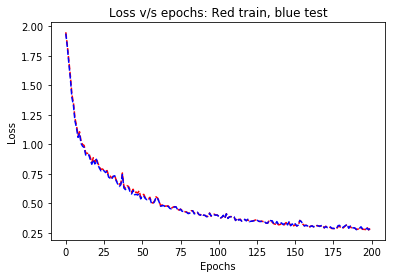

Text(0.5, 1.0, 'ACC v/s epochs: Red train, blue test')

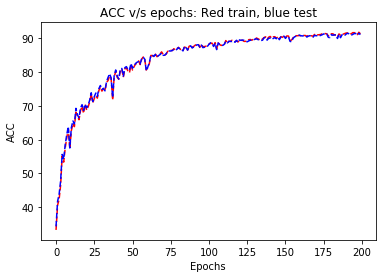

In [0]:
C = 10
F = 784
model = FFNN(F, [256, 128, 64], [relu, sig, relu], [None, None, None], C, l2_par=None, keep_prob=[1.0,0.7,0.7,1.0])  
optimizer = SGD(model.parameters(), 1e-2,0)

with torch.no_grad():
  loss, acc, loss_test, acc_test = entrenar_FFNN(model, mnist_train_set, mnist_test_set, optimizer, epochs=200, batch_size=32)
t = np.arange(0,200,1)
plt.plot(t, loss, 'r--', t, loss_test, 'b--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s epochs: Red train, blue test")
plt.show()
plt.plot(t, acc, 'r--', t, acc_test, 'b--')
plt.xlabel("Epochs")
plt.ylabel("ACC")
plt.title("ACC v/s epochs: Red train, blue test")


Tercera configuración: Regularizacion con norma l2, l2_par = 0.0002

Epoch:200 Acc:90.03% Loss:0.7453 Tiempo/epoch:12.379s

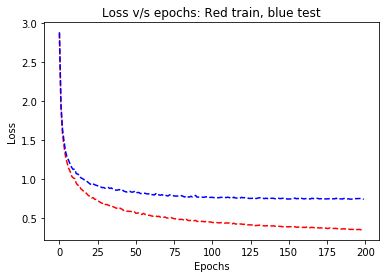

Text(0.5, 1.0, 'ACC v/s epochs: Red train, blue test')

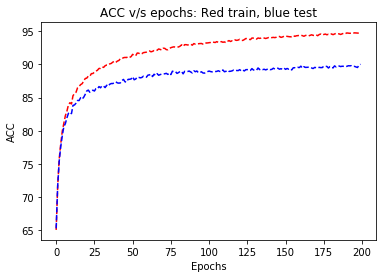

In [0]:
C = 10
F = 784
model = FFNN(F, [256, 128, 64], [relu, sig, relu], [None, None, None], C, l2_par=0.0002, keep_prob=[1.0,1.0,1.0,1.0])  
optimizer = SGD(model.parameters(), 1e-2,0)

with torch.no_grad():
  loss, acc, loss_test, acc_test = entrenar_FFNN(model, mnist_train_set, mnist_test_set, optimizer, epochs=200, batch_size=32, regloss=True)
t = np.arange(0,200,1)
plt.plot(t, loss, 'r--', t, loss_test, 'b--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s epochs: Red train, blue test")
plt.show()
plt.plot(t, acc, 'r--', t, acc_test, 'b--')
plt.xlabel("Epochs")
plt.ylabel("ACC")
plt.title("ACC v/s epochs: Red train, blue test")


Configuración sin regularizar

Epoch:200 Acc:89.68% Loss:0.3853 Tiempo/epoch:12.108s

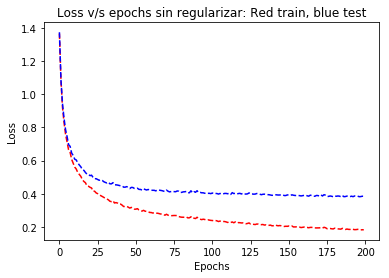

Text(0.5, 1.0, 'ACC v/s epochs: Red train, blue test')

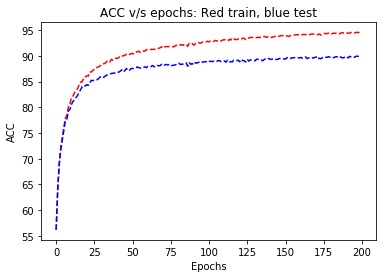

In [0]:
C = 10
F = 784
model = FFNN(F, [256, 128, 64], [relu, sig, relu], [None, None, None], C, l2_par=None, keep_prob=[1.0,1.0,1.0,1.0])  
optimizer = SGD(model.parameters(), 1e-2,0)

with torch.no_grad():
  loss, acc, loss_test, acc_test = entrenar_FFNN(model, mnist_train_set, mnist_test_set, optimizer, epochs=200, batch_size=32)
t = np.arange(0,200,1)
plt.plot(t, loss, 'r--', t, loss_test, 'b--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s epochs sin regularizar: Red train, blue test")
plt.show()
plt.plot(t, acc, 'r--', t, acc_test, 'b--')
plt.xlabel("Epochs")
plt.ylabel("ACC")
plt.title("ACC v/s epochs: Red train, blue test")

De los experimentos realizados anteriormente, se puede apreciar que cuando se utiliza un modelo con regularización de tipo dropout se pueden obtener mejores resultados de accuracy al momento de generalizar. Esto debido a que el modelo no se está aprendiendo de memoria los datos ya que de vez en cuando se apagan neuronas, esto se puede apreciar en las oscilaciones que presenta el gráfico. 

En teoría para todas las redes con regularizaciones deberían presentarse mejores resultados en comparación al modelo sin generalizar, en este caso con weight_decay y l2 no se nota mucho la diferencia, esto se debe a que no pude encontrar los mejores valores para estos hiperparámetros. 

De todas formas, se lograron los objetivos planteados inicialmente de modificar el código anterior para soportar los 3 tipos de regularizaciones, y experimentar con una buena cantidad de épocas. Como desafío queda seguir probando con otros datos, para poder alcanzar los valores óptimas para el weight_decay y l2_param.

# Parte 4 (Opcional): Aumento de datos sintéticamente


In [0]:
# Acá debes agregar tu código para hacer data augmentation sobre los 
# datos de entrenamiento de MNIST

In [0]:
# Reporta cómo cambia el error de prueba y compáralo con no usar data augmentation.